In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_dataloader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_dataloader(path, train_config)

num_classes = train_loader.dataset.dataset.get_classes()


Load data from ./data/celebaA_data.pkl


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016265245..1.0038486].


0


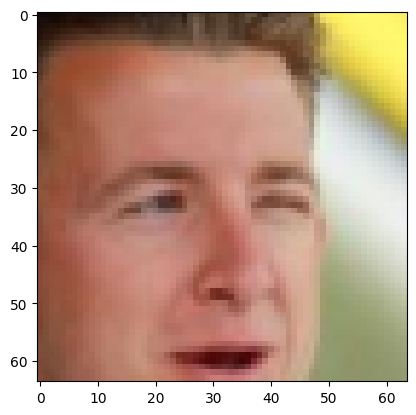

In [6]:
# Plot an image from train_loader
import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
found = False
while not found:
    images, labels = next(iter(train_loader))
    labels = labels.numpy()
    for i in range(len(labels)):
        if labels[i] == 0:
            print(labels[i])
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            plt.show()
            found = True
            break


In [5]:
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18
from examples.mia.celebA_HQ.utils.celeb_hq_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

import torch
# Create the model
model = ResNet18(num_classes=num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)



2500


Training Progress: 100%|██████████| 30/30 [19:23<00:00, 38.79s/it]


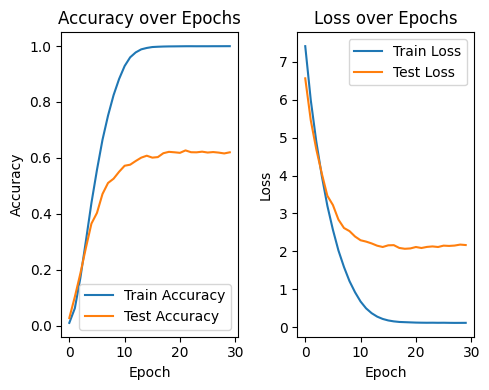

In [7]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Data:
### Pseudo labels -> Top n-selection (test data on target)

### Train:
### GAN (with pseudo labels) - This goes under @prepare_attack

### Test:
### Generate a 'fake' image from generator with target label (a class), run this fake image through the target model to get Loss_inv w.r.t target label. Do this in a loop - This goes under @run_attack


In [3]:
# Auxiliary loader

from examples.minv.celebA.utils.celebA_data import get_celebA_auxloader

aux_loader = get_celebA_auxloader(path, train_config)



Load data from ./data/celebaA_aux_data.pkl


In [4]:
import torch
from torch.nn import functional as F
import numpy as np
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18

# We have model_metadata.pkl and target_model.pkl. Load metadata and target model
# Load the model
num_classes = train_loader.dataset.dataset.get_classes()
model = ResNet18(num_classes=num_classes)
model.load_state_dict(torch.load('./target/target_model.pkl'))
model.eval()


ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [5]:
# Top-n-selection

# Get the prediction confidence of each image in aux_loader using the target model
# For each image in aux_loader, we expect a vector of length #classes with the confidence of the model
# that the image belongs to each class
def get_prediction_confidence(model, aux_loader):
    model.eval()
    all_confidences = []
    for images, labels in aux_loader:
        with torch.no_grad():
            outputs = model(images)
            confidences = F.softmax(outputs, dim=1)
            all_confidences.append(confidences)
    return torch.cat(all_confidences)

confs = get_prediction_confidence(model, aux_loader)


[(6668, 0.7095228433609009), (42, 0.6871603727340698), (6383, 0.5730782151222229), (6374, 0.5627214312553406), (6667, 0.5328734517097473), (2086, 0.48797422647476196), (663, 0.38215577602386475), (1185, 0.36410897970199585), (574, 0.3572092354297638), (36, 0.28856930136680603)]


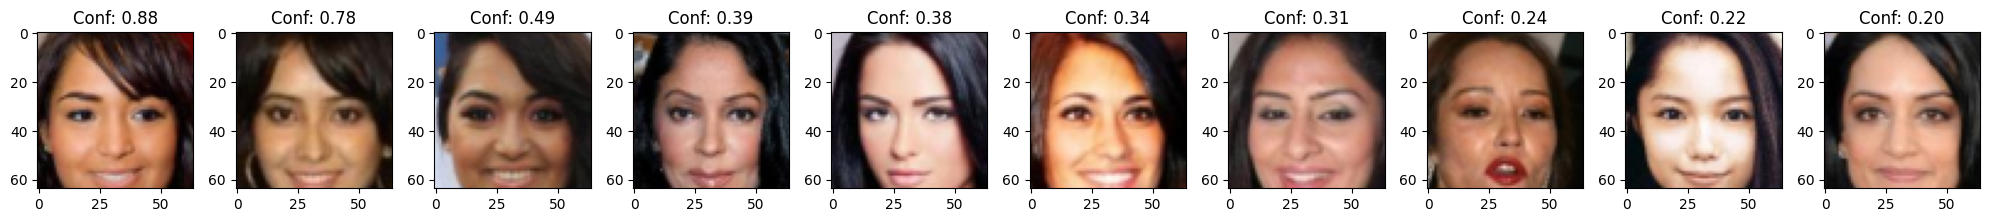

In [12]:
import matplotlib.pyplot as plt

pseudo_labels = torch.max(confs, dim=1)
#print(pseudo_labels)

#empty array of size num_classes
pseudo_map = [[] for _ in range(num_classes)]

for i, (conf, label) in enumerate(zip(pseudo_labels[0], pseudo_labels[1])):
    pseudo_map[label.item()].append((i, conf.item()))

# Sort pseudo_map by confidence descending
for i in range(num_classes):
    pseudo_map[i] = sorted(pseudo_map[i], key=lambda x: x[1], reverse=True)

# keep only the top n entries in each element of pseudo_map
n = 10
pseudo_map = [pseudo_map[i][:n] for i in range(num_classes)]

print(pseudo_map[0])

# Plot images with their pseudo labels for class 0
plt.figure(figsize=(20, 10))
for i, (idx, conf) in enumerate(pseudo_map[1]):
    plt.subplot(1, n, i + 1)
    plt.imshow(np.transpose(aux_loader.dataset[idx][0], (1, 2, 0)))
    plt.title(f'Conf: {conf:.2f}')
plt.tight_layout()
plt.show()

In [11]:
# save images with pseudo labels into subfolders
import os
from PIL import Image

# Create a directory to store the pseudo-labeled images
pseudo_dir = os.path.join(data_folder, 'pseudo')
os.makedirs(pseudo_dir, exist_ok=True)

# Create subdirectories for each class
for i in range(num_classes):
    os.makedirs(os.path.join(pseudo_dir, str(i)), exist_ok=True)

# Copy the images to the corresponding subdirectories
for i in range(num_classes):
    for idx, _ in pseudo_map[i]:
        img, _ = aux_loader.dataset[idx]
        # convert tensor to PIL image
        img = img.permute(1, 2, 0).numpy()
        img = Image.fromarray((img * 255).astype(np.uint8))
        img.save(os.path.join(pseudo_dir, str(i), f'{idx}.png'))
        
        

In [16]:
# Load pseudo data loader
from examples.minv.celebA.utils.celebA_data import get_celebA_pseudoloader

pseudo_loader = get_celebA_pseudoloader(path, train_config)

Load data from ./data/celebaA_pseudo_data.pkl


In [28]:
# GAN training
from examples.minv.celebA.utils.generator import ResNetGenerator
from examples.minv.celebA.utils.discriminator import SNResNetProjectionDiscriminator
import examples.minv.celebA.utils.losses as losses 
import kornia
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dim_z = 256

# Initialize the generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z, activation=F.relu, bottom_width=16).to(device)
dis = SNResNetProjectionDiscriminator(num_classes=num_classes, activation=F.relu).to(device)

# Load optimizers
opt_gen = torch.optim.Adam(gen.parameters(), 0.002, (0.0, 0.9))
opt_dis = torch.optim.Adam(dis.parameters(), 0.00002, (0.0, 0.9))

# Adversarial losses
gen_criterion = losses.GenLoss(loss_type='hinge', is_relativistic=False)
dis_criterion = losses.DisLoss(loss_type='hinge', is_relativistic=False)

# Augmentations for generated images
aug_list = kornia.augmentation.container.ImageSequential(
        #kornia.augmentation.RandomResizedCrop((64, 64), scale=(0.8, 1.0), ratio=(1.0, 1.0)),
        kornia.augmentation.ColorJitter(brightness=0.2, contrast=0.2, p=0.5),
        kornia.augmentation.RandomHorizontalFlip(),
        kornia.augmentation.RandomRotation(5),
    ).to(device)

In [29]:
# Training loop
n_iter = 500
n_dis = 1
alpha = 0.2
log_interval = 10

model.to(device)
model.eval()


torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.benchmark = True

def sample_from_generator(gen, n_classes, batch_size, device):
    """Sample random z and y from the generator"""
    
    z = torch.empty(batch_size, dim_z, dtype=torch.float32, device=device).normal_()
    y = torch.randint(0, n_classes, (batch_size,)).to(device)
    return gen(z, y), y, z


gen_losses = []
dis_losses = []
inv_losses = []

# Training loop
for i in range(n_iter):
    _l_g = .0
    cumulative_inv_loss = 0.
    cumulative_loss_dis = .0

    cumulative_target_acc = .0
    target_correct = 0
    count = 0
    for j in range(n_dis):
        if j == 0:
            fake, fake_labels, _ = sample_from_generator(gen, num_classes, 128, device)
            fake_aug = aug_list(fake)
            dis_fake = dis(fake_aug, fake_labels)

            inv_loss = losses.max_margin_loss(model(fake_aug), fake_labels)

            inv_losses.append(inv_loss.item())
            dis_real = None

            loss_gen = gen_criterion(dis_fake, dis_real)
            gen_losses.append(loss_gen.item())
            loss_all = loss_gen + inv_loss*alpha

            gen.zero_grad()
            loss_all.backward()
            opt_gen.step()
            _l_g += loss_gen.item()
            cumulative_inv_loss += inv_loss.item()

        fake, fake_labels, _ = sample_from_generator(gen, num_classes, 128, device)

        real, real_labels = next(iter(pseudo_loader))
        real, real_labels = real.to(device), real_labels.to(device)

        dis_fake = dis(fake, fake_labels)
        dis_real = dis(real, real_labels)

        loss_dis = dis_criterion(dis_fake, dis_real)
    
        if loss_dis.item() > 0.1:
        
            dis.zero_grad()
        
            loss_dis.backward()
            opt_dis.step()

        cumulative_loss_dis += loss_dis.item()
        dis_losses.append(cumulative_loss_dis/n_dis)
        
        with torch.no_grad():
            count += fake.shape[0]
            T_logits = model(fake)
            T_preds = T_logits.max(1, keepdim=True)[1]
            target_correct += T_preds.eq(fake_labels.view_as(T_preds)).sum().item()
            cumulative_target_acc += round(target_correct / count, 4)

    if i % log_interval == 0:
        print(
                'iteration: {:05d}/{:05d}, loss gen: {:05f}, loss dis {:05f}, inv loss {:05f}, target acc {:04f}'.format(
                    i, n_iter, _l_g, cumulative_loss_dis, cumulative_inv_loss,
                    cumulative_target_acc, ))
        
        if cumulative_target_acc > 0.2:
            break

# Save the generator and discriminator
torch.save(gen.state_dict(), 'generator.pth')
torch.save(dis.state_dict(), 'discriminator.pth')


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.56 GiB of which 26.75 MiB is free. Including non-PyTorch memory, this process has 14.54 GiB memory in use. Of the allocated memory 12.52 GiB is allocated by PyTorch, and 1.84 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

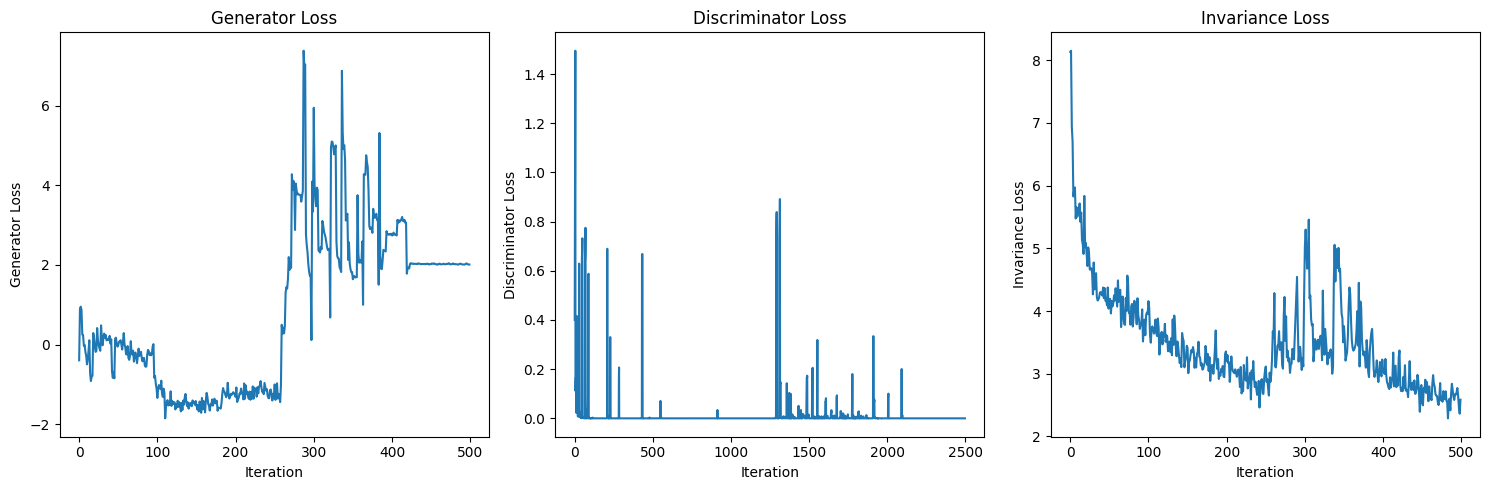

In [47]:
import matplotlib.pyplot as plt
# Plot all 3 losses
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(gen_losses)
plt.xlabel('Iteration')
plt.ylabel('Generator Loss')
plt.title('Generator Loss')

plt.subplot(1, 3, 2)
plt.plot(dis_losses)
plt.xlabel('Iteration')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss')

plt.subplot(1, 3, 3)
plt.plot(inv_losses)
plt.xlabel('Iteration')
plt.ylabel('Invariance Loss')
plt.title('Invariance Loss')

plt.tight_layout()
plt.show()


### Model Inversion Attack on Identifier Model 

tensor([ 270, 2436, 2080,  515], device='cuda:0')


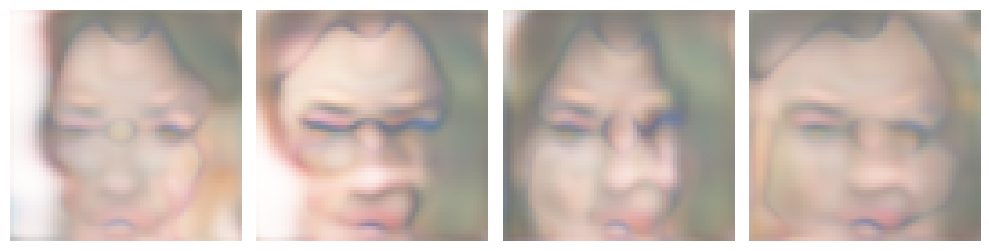

tensor(0.4946, device='cuda:0')


In [ ]:
from examples.minv.celebA.utils.generator import ResNetGenerator
from examples.minv.celebA.utils.discriminator import SNResNetProjectionDiscriminator
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dim_z = 256
# Load generator and discriminator
gen = ResNetGenerator(num_classes=num_classes, dim_z=dim_z).to(device)
gen.load_state_dict(torch.load('generator_2.pth'))

dis = SNResNetProjectionDiscriminator(num_classes=num_classes).to(device)
dis.load_state_dict(torch.load('discriminator_2.pth'))

# Generate images
gen.eval()

n_images = 4
z = torch.empty(n_images, dim_z, dtype=torch.float32, device=device).normal_()
y = torch.randint(0, num_classes, (n_images,)).to(device)

print(y) 

with torch.no_grad():
    fake = gen(z, y)

# Normalize the generated images to the range [0, 1]
fake = (fake + 1) / 2

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(1, n_images, i + 1)
    plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()


# check l2 distance between generated images
from torch.nn.functional import mse_loss

def l2_distance(images):
    images = images.view(images.size(0), -1)
    return mse_loss(images, torch.zeros_like(images))

print(l2_distance(fake))

In [ ]:
# TODO: Write code for our handler
#       Write audit.yaml

# Import input handler
#from examples.mia.celebA_HQ.utils.celeb_hq_input_handler import CelebAHQInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
#leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
#mia_results = leakpro.run_audit(return_results=True)
